# Simulating an Interferometer

In this notebook, interferometers are introduced and described. Then, the [EVLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview) (in its D-configuration) is simulated. For this, the path of the incoming image is traced and then reconstructed.

## What is an interferometer?

All telescopes (optical or not) have an inherent limit to their resolution due to the effects of light diffracting around the telescopes aperture. This limit is known as the Rayleigh limit, which is defined as the point where two point sources can no longer be seen as two different sources. It is defined by $\theta = 1.22 \frac{\lambda}{D}$, where: $\theta$ is the angular distance; $\lambda$ is the wavelength of the light at which you are operating; and $D$ is the diameter of the telescope aperature. The number $1.22$ comes from the distance to the first minimum of an Airy disk (which is the diffraction pattern of a circular disk, which is the shape of the telescope aperture).

![Rayleigh Criterion](img/Rayleigh_criterion.png)
> The above image ([source](https://www.radio2space.com/introduction-to-radio-interferometry/)) visually shows the Rayleigh Criterion, which is used as the lower limit to angular distance after which the two sources can no longer be resolved separately. Note that each individual source is diffracted into an Airy Disk.

The problem with radio telescopes is that the radio waves have very large wavelengths, which means immense dishes are needed to get good resolution. For example, the Hubble Space Telescope has an aperture size of $2.4$m and observes visible light has wavelengths from $\approx 400$ to $700$nm (let's take $600$m as an example)

In [1]:
wavelength_hst = 600*10**(-9)
aperture_size_hst = 2.4

Therefore, the angular resolution of the Hubble Telescope is:

In [2]:
angular_res = 1.22*wavelength_hst/aperture_size_hst
angular_res

3.0500000000000004e-07

For a radio telescope with similar angular resolution, that observes at $1$GHz (this has wavelength of $0.3$m):

In [3]:
wavelength_radio = 0.3
aperture_size_radio = 1.22*wavelength_radio/angular_res
aperture_size_radio

1199999.9999999998

From this, you can see that a dish $1200$km is needed to get such good angular resolution. This is simply infeasible to build.

Because buiding normal full dishes are inpractical, interferometers are used. Interferometers, in the simplest terms, use many smaller telescopes dispersed over a large area to imitate a large dish. This way, much high angular resolutions can be achieved than using the telescopes alone would provide. This has the added advantage that the telescopes can be separated by very large distances (like across continents) to see small angular resolutions for relatively little additional cost.

However, the sensitivity of the telescope is proportianal to the collecting area. Since interferometers have large sections of the "full dish" unmeasured, they suffer greatly in the sensitivity department and struggle to see dim sources. This means that long observing times are typically needed. 

## How it works

If you consider the light from a source getting diffracted through a double slit, an inverse relationship can be noticed between the angular size of the source and the fringe visibility (i.e. the response function). There is, in fact, a fourier transform relationship between the shape of the source and the response function.
There is also an effect from the shape and distance between the two slits. If the distance between the slits is large, the response function is sensitive to small scale structure in the source and vice versa.

The radio interferometer is anextension of this idea. Each pair of telescopes effectively form a double slit diffractor. Therefore, each pair of telescopes will give information on the source (specifically, each pair gives a spatial frequency and its orientation).

## The UVW baseline

The [EVLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview) has many telescopes. The telescopes used in the D-configuration has the following shape. Note that the distance is measured in nanoseconds (i.e. time taken for light to travel the distance)

In [4]:
import interferometer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

antennae_positions = interferometer.choose_ant(configuration="D")

Text(0.5, 0, 'Lz(ns)')

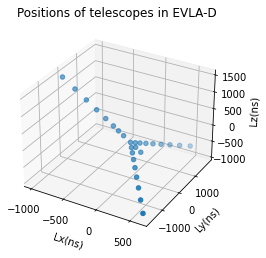

In [5]:
fig_xyz = plt.figure()
ax_xyz = fig_xyz.add_subplot(111, projection='3d')

ax_xyz.scatter(antennae_positions['Lx(ns)'], antennae_positions['Ly(ns)'], antennae_positions['Lz(ns)'])
ax_xyz.set_title('Positions of telescopes in EVLA-D')
ax_xyz.set_xlabel('Lx(ns)')
ax_xyz.set_ylabel('Ly(ns)')
ax_xyz.set_zlabel('Lz(ns)')

In this case the positions are in the XYZ coordinate. The Z-axis is alinged with Earth's rotation axis, the Y-axis points East and the X-axis is in such a direction as to get a right-handed coordinate system.

The most useful coordinate system is the UVW coordinate system. This is the view of the telescope system from the point of view of the target star. The W-axis points along the observing direction, the U-axis points along the meridian defined by the hour angle, and the V-axis finishes the right-handed coordinate system. The transformation from the XYZ coordinate frame to the UVW coordinate frame is the following rotation.

\begin{gather}
    \begin{bmatrix}
        U \\ V \\ W
    \end{bmatrix}
    =
    \begin{bmatrix}
        \sin H & \cos H & 0 \\
        - \sin \delta \cos H & \sin \delta \sin H  & \cos \delta \\
        \cos \delta \cos H & - \cos \delta \sin H & \sin \delta
    \end{bmatrix}
    \begin{bmatrix}
        X \\ Y \\ Z
    \end{bmatrix}
\end{gather}
    

where $H$ is the hour angle of the target and $\delta$ is the declination of the target. Hour angle and declination form a coordinate system that map the sky and are analogous to latittude and longitude.

The positions of the telescopes in UVW coordinates for observing a target at declination of $+45$ and an hour angle of $0.0$ are as follows.

Text(0.5, 0, 'W(ns)')

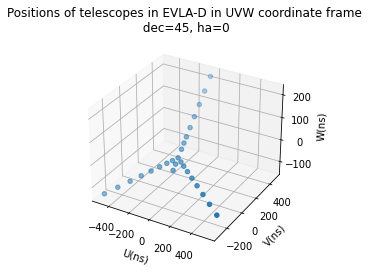

In [6]:
declination = 45
hour_angle = 0
UVW_matrix = interferometer.convert_XYZ_to_UVW(antennae_positions, declination, hour_angle)
fig_uvw = plt.figure()
ax_uvw = fig_uvw.add_subplot(111, projection="3d")
ax_uvw.scatter(UVW_matrix[0], UVW_matrix[1], UVW_matrix[2])
ax_uvw.set_title('Positions of telescopes in EVLA-D in UVW coordinate frame\n dec={}, ha={}'.format(declination, hour_angle))
ax_uvw.set_xlabel('U(ns)')
ax_uvw.set_ylabel('V(ns)')
ax_uvw.set_zlabel('W(ns)')

The geaometric delay between each pair of telescopes is removed (see image below) and sent to a correlator which will combine the systems. 

![2 element interferometer](img/2-element_interferometer.png)

> This image (from lecture slides) shows a diagram of a 2-element interferometer (with telescopes named **R1** and **R2**. $b$ is the baseline (distance between the two telescopes), $\theta$ is the angular distance between the source and the zenith. It can be seen that **R1** is delayed by a time of $\tau_g$ where $\tau_g c = b \sin{\theta}$ relative to **R2**. This delay is added to **R2** and the two signals are then combined in the correlator, **C**.

Each pair of telescopes will create one point in the aperture plane at the baseline vector. 

The aperture plane for the EVLA is seen below. This is found by finding the vector difference between every pair of telescopes. 

Text(0, 0.5, 'V(ns)')

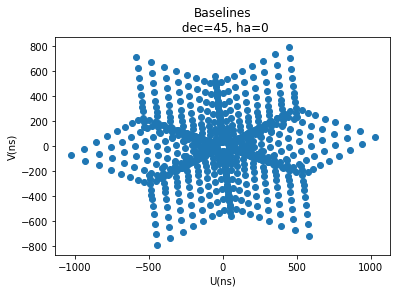

In [7]:
baselines = interferometer.make_baselines(declination, [hour_angle], antennae_positions)
fig_base =  plt.figure()
ax_base = fig_base.add_subplot(111)
ax_base.scatter(baselines[0], baselines[1])
ax_base.set_title('Baselines\n dec={}, ha={}'.format(declination, hour_angle))
ax_base.set_xlabel('U(ns)')
ax_base.set_ylabel('V(ns)')

The above baselines are generated by the UVW coordinates at an hour angle of 0. As the Earth rotates, the position of the target relative to the telescopes changes. This results in the baselines tracing out ellipses  over time. 
The following baselines are calculated by observing from $H=-0.5$ to $H=+0.5$ observing every 30 seconds.

In [8]:
hour_angle_set = np.arange(-0.5, 0.5, 30/3600)

Text(0, 0.5, 'V(ns)')

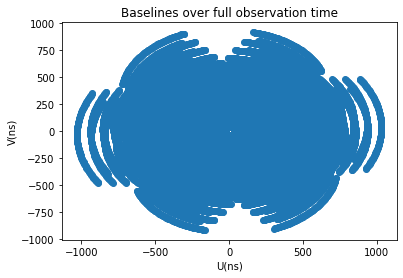

In [9]:
full_baselines = interferometer.make_baselines(declination, hour_angle_set, antennae_positions)
fig_full_base =  plt.figure()
ax_full_base = fig_full_base.add_subplot(111)
ax_full_base.scatter(full_baselines[0], full_baselines[1])
ax_full_base.set_title('Baselines over full observation time')
ax_full_base.set_xlabel('U(ns)')
ax_full_base.set_ylabel('V(ns)')

As can be seen, a large part of the space is covered.
This can be better seen as sampling function, $S(u,v)$, which is defined as $S=1$, where a baseline vector exists and $S=0$ elsewhere.

[[ 31.7433842   71.32913842 121.71849124 ... -91.49309741 -63.95683544
  -33.46804801]
 [-29.17804654 -22.90259616 -14.90627666 ... 219.12147556 153.11596284
   80.03662762]
 [  3.57957083  24.21571514  50.50583722 ... 124.18172874  86.75697744
   45.33298839]]
(3, 84240)


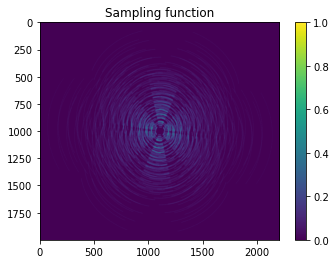

In [10]:
sampling_function = interferometer.make_sampling_func(full_baselines)
plt.imshow(sampling_function, interpolation='gaussian')
plt.title('Sampling function')
plt.colorbar()

Each of these baselines contribute some information on the spatial distribution of the target. The small baselines (from telescopes near each other) are sensitive to large scale variation, while large baselines are sensitive to small angular resolutions but insensitive to small scale structures. From this, it can be seen that full coverage of the aperture plane will provide enough information to recondtruct a full image of the target. However, by neccessity, there are gaps in the sampling function (because we are using many separate telescopes). This results in the reconstructed image being convoluted by a point spread function. This point spread function is the 2D Fourier Transform of the sampling function. 

Zooming into the centre:

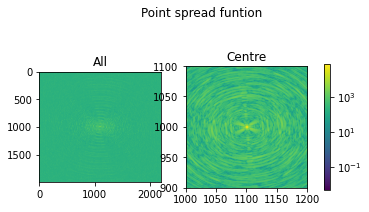

In [47]:
img_width = 100

psf_fig, psf_axes = plt.subplots(nrows=1, ncols=2)
psf_fig.suptitle('Point spread funtion')
plt.subplots_adjust(top=1)

im = psf_axes[0].imshow(np.abs(dirty_beam), norm=matplotlib.colors.LogNorm())
psf_axes[0].set_title('All')

clim=im.properties()['clim']
psf_axes[1].imshow(np.abs(dirty_beam), norm=matplotlib.colors.LogNorm(), clim=clim)
psf_axes[1].set_ylim(len(dirty_beam)//2-img_width, len(dirty_beam)//2+img_width)
psf_axes[1].set_xlim(len(dirty_beam[0])//2-img_width, len(dirty_beam[0])//2+img_width)
psf_axes[1].set_title('Centre')
psf_fig.colorbar(im, ax=psf_axes.ravel().tolist(), shrink=0.5, location='right')
#plt.tight_layout()

## Image

$R(u,v) = e^{i k \mathbf{B \cdot s}} \int{I(x,y) e^{2\pi i (u x +v y)} dx dy}$

The response can be divided into two parts: 1) a set of fast fringes (the initial exponential bit) that are modified by 2) a fourier transform of the source brightness distribution.

Since the Fast fringes do not depend on the source but only on the geometry of the telescopes and the observing direction, most radio interferometers remove its effect automatically at the very start of the data processing. 

This means that the effect of the W-axis can be effectively ignored. Leaving just the UV plane.

The baselines can be better seen in a sampling function (which is simply a function that is 1 where the baseline is present and 0 elsewhere)

The fourier transform of the sampling function (known as the dirty beam)